# Basic of Guassian processes

## References: http://bridg.land/posts/gaussian-processes-1 and Chapter 6 of PRML
An explaination of kernel https://stats.stackexchange.com/questions/152897/how-to-intuitively-explain-what-a-kernel-is

After reading some materials, I think the key point of guassian processes is based on modeling the prior distribution of function using proper kernels and the provided train data, the predictive distribution for new dataset can then be obtained by bayes rule. Not only the predicted values can be obtained, but also the uncertainty of the estimates can be provided.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def plot_unit_gaussian_sample(dim, sample_num):

    xs = np.linspace(0, 1, dim)

    plt.figure()

    for _ in range(sample_num):
        ys = np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        plt.plot(xs, ys, linewidth=1)

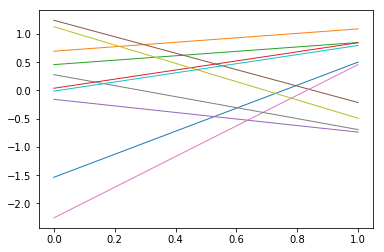

In [3]:
plot_unit_gaussian_sample(2, 10)

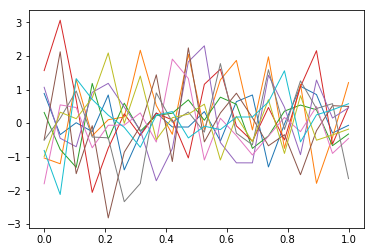

In [4]:
plot_unit_gaussian_sample(20, 10)

In [5]:
def k(x1, x2, theta0 = 1, theta1 = 1, theta2 = 0, theta3 = 0):
    """ exponential of a quadratic form with the addition of constant and linear terms (6.63 in PRML) """
    dx = np.expand_dims(x1, 1) - np.expand_dims(x2, 0)

    return theta0 * np.exp(-theta1*(dx**2)/2) + theta2 + theta3 * np.expand_dims(x1, 1) * np.expand_dims(x2, 0)


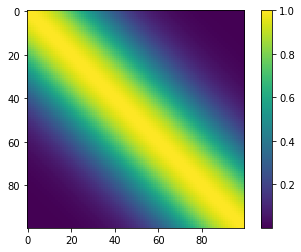

In [6]:
x1 = np.linspace(-2, 2, 100)
x2 = np.linspace(-2, 2, 100)
cov = k(x1, x2)
plt.imshow(cov)
plt.colorbar()

In [7]:
def plot_unit_gaussian_sample_with_k(dim, xs, sample_num):

    # xs = np.linspace(0, 1, dim)

    plt.figure()

    for _ in range(sample_num):
        ys = np.random.multivariate_normal(np.zeros(dim), k(xs,xs))
        plt.plot(xs, ys, linewidth=1)

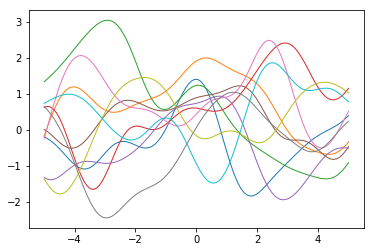

In [8]:
xs = np.linspace(-5,5,100)
plot_unit_gaussian_sample_with_k(100, xs, 10)

## Guassian processes for regression (without noise)

In [10]:
def poly_f(xs):
    """ ground truth polynomial function from 
    http://bridg.land/posts/gaussian-processes-1
    """

    return 0.03 * xs**5 + 0.2 * xs**4 - 0.1 * xs**3 - 2.4 * xs**2 - 2.5 * xs + 6

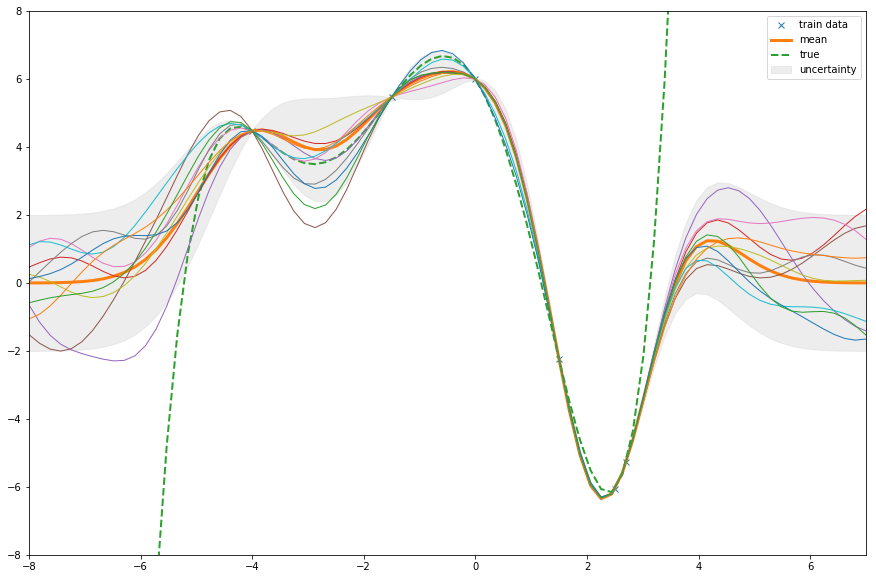

In [13]:
# train data
x_obs = np.array([-4, -1.5, 0, 1.5, 2.5, 2.7])
y_obs = poly_f(x_obs)
# new data
x_s = np.linspace(-8, 7, 80)
# kernel function
K = k(x_obs, x_obs)
K_s = k(x_obs, x_s)
K_ss = k(x_s, x_s)
K_sTinv = np.matmul(K_s.T, np.linalg.pinv(K))

# mean of prediction and the uncertainty
mu_s = np.matmul(K_sTinv, y_obs)
Sigma_s = K_ss - np.matmul(K_sTinv, K_s)
stds = np.sqrt(Sigma_s.diagonal())

plt.figure(figsize=(15,10))
plt.plot(x_obs, y_obs, 'x', label='train data')
plt.fill_between(x_s, mu_s - 2 * stds, mu_s + 2 * stds, alpha=0.4, color='lightgray', label = 'uncertainty')
plt.plot(x_s, mu_s, linewidth = 3, label = 'mean')
plt.plot(x_s, poly_f(x_s), '--', linewidth = 2, label = 'true')

# samples from the predicted distribution
for _ in range(10):
    ys = np.random.multivariate_normal(mu_s, Sigma_s)
    plt.plot(x_s, ys, linewidth = 1)

plt.ylim([-8, 8])
plt.xlim([-8, 7])
plt.legend()

### Change the kernel

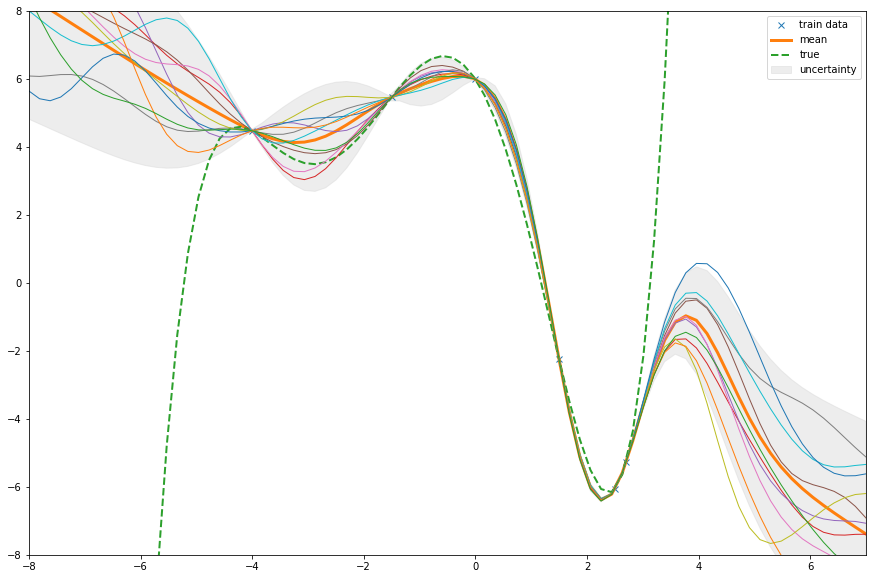

In [14]:
# train data
x_obs = np.array([-4, -1.5, 0, 1.5, 2.5, 2.7])
y_obs = poly_f(x_obs)
# new data
x_s = np.linspace(-8, 7, 80)
# kernel function
K = k(x_obs, x_obs, theta3 = 1)
K_s = k(x_obs, x_s, theta3 = 1)
K_ss = k(x_s, x_s, theta3 = 1)
K_sTinv = np.matmul(K_s.T, np.linalg.pinv(K))

# mean of prediction and the uncertainty
mu_s = np.matmul(K_sTinv, y_obs)
Sigma_s = K_ss - np.matmul(K_sTinv, K_s)
stds = np.sqrt(Sigma_s.diagonal())

plt.figure(figsize=(15,10))
plt.plot(x_obs, y_obs, 'x', label='train data')
plt.fill_between(x_s, mu_s - 2 * stds, mu_s + 2 * stds, alpha=0.4, color='lightgray', label = 'uncertainty')
plt.plot(x_s, mu_s, linewidth = 3, label = 'mean')
plt.plot(x_s, poly_f(x_s), '--', linewidth = 2, label = 'true')

# samples from the predicted distribution
for _ in range(10):
    ys = np.random.multivariate_normal(mu_s, Sigma_s)
    plt.plot(x_s, ys, linewidth = 1)

plt.ylim([-8, 8])
plt.xlim([-8, 7])
plt.legend()

## Guassian processes for regression (with noise)

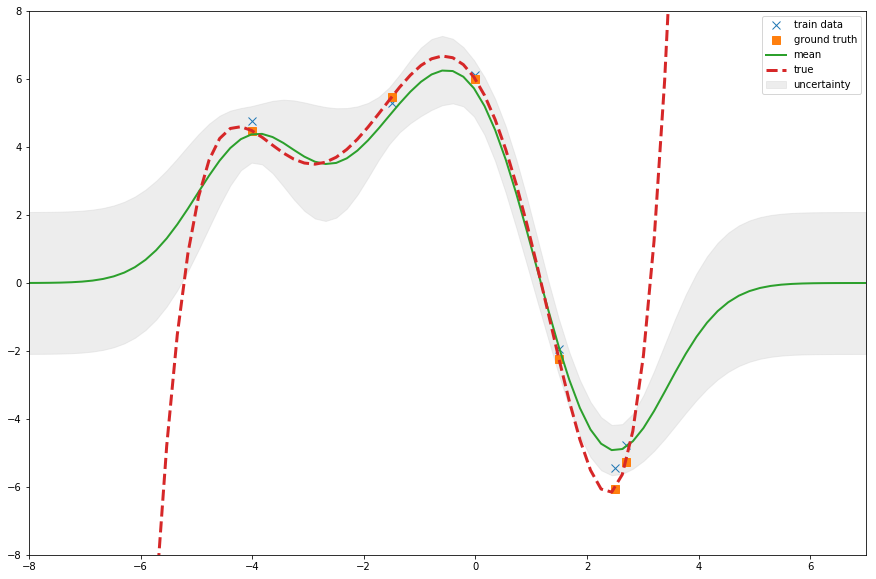

In [17]:
x_obs = np.array([-4, -1.5, 0, 1.5, 2.5, 2.7])
sigma_noise = 0.3 # std of noise
beta = 1 / (sigma_noise**2) # precision defined by Figure 1.16 in PRML
y_obs = poly_f(x_obs) + np.random.normal(0,sigma_noise,len(x_obs))
y_true = poly_f(x_obs)
x_s = np.linspace(-8, 7, 80)
# kernel function with noise prior (6.62 in PRML)
K = k(x_obs, x_obs) + np.diag(np.ones_like(x_obs)*1/beta)
K_s = k(x_obs, x_s)
K_ss = k(x_s, x_s) + np.diag(np.ones_like(x_s)*1/beta)
K_sTinv = np.matmul(K_s.T, np.linalg.pinv(K))
mu_s = np.matmul(K_sTinv, y_obs)
Sigma_s = K_ss - np.matmul(K_sTinv, K_s)
stds = np.sqrt(Sigma_s.diagonal())

plt.figure(figsize=(15,10))
plt.plot(x_obs, y_obs, 'x', label='train data', markersize=8)
plt.plot(x_obs, y_true, 's', label='ground truth', markersize=8)
plt.fill_between(x_s, mu_s - 2 * stds, mu_s + 2 * stds, alpha=0.4, color='lightgray', label = 'uncertainty')
plt.plot(x_s, mu_s, linewidth = 2, label = 'mean')
plt.plot(x_s, poly_f(x_s), '--', linewidth = 3, label = 'true')

# for _ in range(10):
#     ys = np.random.multivariate_normal(mu_s, Sigma_s)
#     plt.plot(x_s, ys, linewidth = 1)

plt.ylim([-8, 8])
plt.xlim([-8, 7])
plt.legend()

### Change the kernel

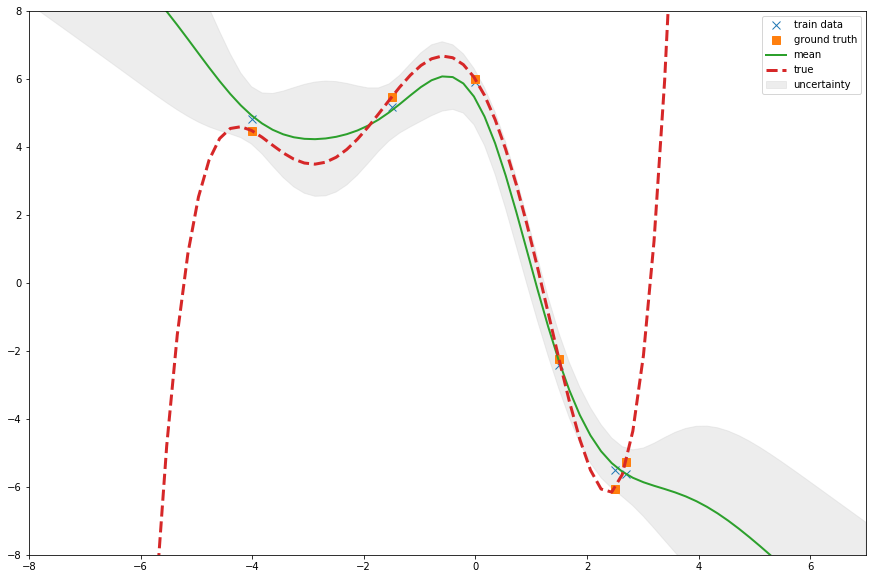

In [18]:
x_obs = np.array([-4, -1.5, 0, 1.5, 2.5, 2.7])
sigma_noise = 0.3 # std of noise
beta = 1 / (sigma_noise**2) # precision defined by Figure 1.16 in PRML
y_obs = poly_f(x_obs) + np.random.normal(0,sigma_noise,len(x_obs))
y_true = poly_f(x_obs)
x_s = np.linspace(-8, 7, 80)
# kernel function with noise prior (6.62 in PRML)
K = k(x_obs, x_obs, theta3 = 1) + np.diag(np.ones_like(x_obs)*1/beta)
K_s = k(x_obs, x_s, theta3 = 1)
K_ss = k(x_s, x_s, theta3 = 1) + np.diag(np.ones_like(x_s)*1/beta)
K_sTinv = np.matmul(K_s.T, np.linalg.pinv(K))
mu_s = np.matmul(K_sTinv, y_obs)
Sigma_s = K_ss - np.matmul(K_sTinv, K_s)
stds = np.sqrt(Sigma_s.diagonal())

plt.figure(figsize=(15,10))
plt.plot(x_obs, y_obs, 'x', label='train data', markersize=8)
plt.plot(x_obs, y_true, 's', label='ground truth', markersize=8)
plt.fill_between(x_s, mu_s - 2 * stds, mu_s + 2 * stds, alpha=0.4, color='lightgray', label = 'uncertainty')
plt.plot(x_s, mu_s, linewidth = 2, label = 'mean')
plt.plot(x_s, poly_f(x_s), '--', linewidth = 3, label = 'true')

# for _ in range(10):
#     ys = np.random.multivariate_normal(mu_s, Sigma_s)
#     plt.plot(x_s, ys, linewidth = 1)

plt.ylim([-8, 8])
plt.xlim([-8, 7])
plt.legend()